In [1]:
from fbprophet import Prophet 
import pandas as pd

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us.csv")

# engineer new cases
df['new_cases'] = df.cases - df.cases.shift().fillna(0)
print(df.head())

# create pandas time series
df.date = pd.to_datetime(df.date)
df.set_index('date',inplace=True)
df['rolling_weekly_avg'] = df.new_cases.rolling(window=7).mean().fillna(0)

# create timeseries readable by fbprophet
ts = pd.DataFrame({'ds':df.index,'y':df.new_cases})
#ts['cap'] = 30000 # unused in linear growth
#ts['floor'] = 0 # unused in linear growth
ts.head()

         date  cases  deaths  new_cases
0  2020-01-21      1       0        1.0
1  2020-01-22      1       0        0.0
2  2020-01-23      1       0        0.0
3  2020-01-24      2       0        1.0
4  2020-01-25      3       0        1.0


,ds,y
date,,
2020-01-21,2020-01-21,1.0
2020-01-22,2020-01-22,0.0
2020-01-23,2020-01-23,0.0
2020-01-24,2020-01-24,1.0
2020-01-25,2020-01-25,1.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


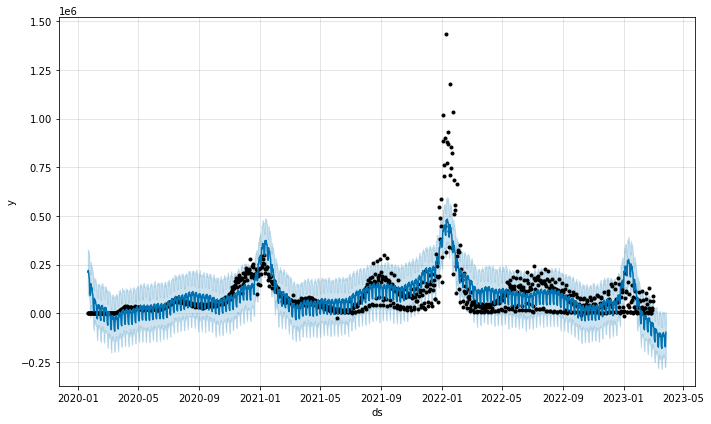

In [6]:
prop = Prophet()
prop.fit(ts)


## create future dataframe

future = prop.make_future_dataframe(periods = 25)
forecast = prop.predict(future) 
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

fig = prop.plot(forecast,)

## Add lines to detect the change point

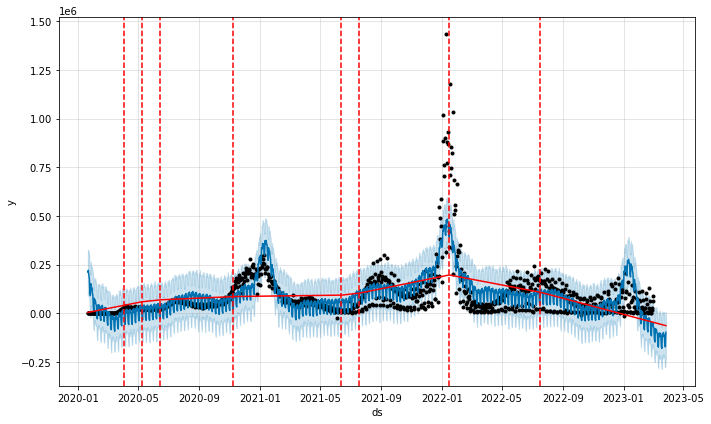

In [8]:
from fbprophet.plot import add_changepoints_to_plot
a = add_changepoints_to_plot(fig.gca(),prop,forecast,)
fig

        -- We didnt tune the model, yet it has captured many changes and points. Lets see after tuning how well it goes

Misses the downturn: Prophet was unable to incorporate the downturn in new COVID cases after the new year. This is because the default setting for the range of data points considered when identifying changepoints is the first 80% of data in the time series. We can fix this by setting changepoint_range = 1 when instantiating the model which will incorporate 100% of the data. In other situations, it may be good to keep the changepoint range at 80% or lower to ensure that the model doesn’t overfit your data and can understand the last 20% on its own. But, in this case, because we are just trying to accurately model what has happened so far, we’ll allow the adjustment to 100%.


Strength of changepoints: While its great prophet was able to create change points, it visually seems like some of the changepoints are quite weak in impact on the model, or possibly there aren’t enough changepoints. The changepoint_prior_scale and the n_changepoints hyperparameters allow us to adjust this. By default, changepoint_prior_scale it is set to 0.05, increasing this value allows the automatic detection of more change points and decreases it allows for less. Alternatively, we can specify a number of changepoints to detect using n_changepoints or list the changepoints ourselves using changepoints. Be careful with this, as too many changepoints may cause overfitting.


Possible overfitting due to seasonality: While it's cool that it picked up on the weekly seasonality of new cases, in this particular context it's more important to understand the overall trend of cases to possibly predict when the pandemic will end. Prophet has built-in hyperparameters to allow you to adjust daily, weekly and yearly seasonality. So we can fix this by setting weekly_seasonality = False. Alternatively, we could try to create our own custom seasonality and adjust the Fourier order using the.add_seasonality()method or we could dampen the automatic seasonality using the seasonality_prior_scale hyperparameter. However, in this case, it might be a little overkill to use either of those options

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


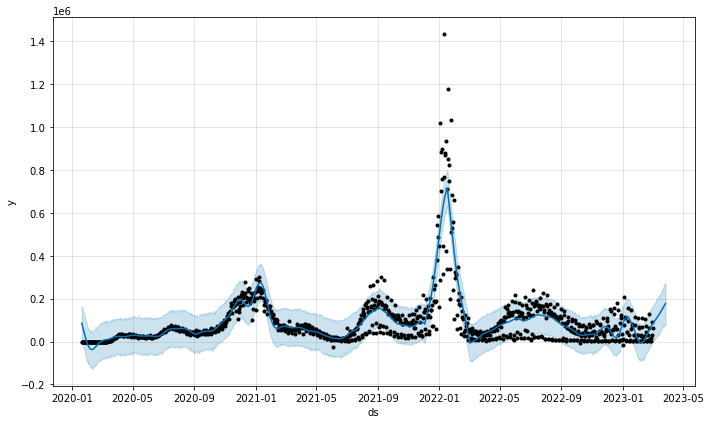

In [9]:
prophet = Prophet(weekly_seasonality=False, changepoint_range=1,changepoint_prior_scale=0.75,)
prophet.fit(ts)

# create a future data frame 
future = prophet.make_future_dataframe(periods=25)
forecast = prophet.predict(future)

# display the most critical output columns from the forecast
forecast[['ds','yhat','yhat_lower','yhat_upper']].head()

# plot
fig = prophet.plot(forecast)

## A better fit now just by tuing the hyper-parameters